In [40]:
import os
import pyspark 
from pyspark.sql import SparkSession
import sys
import seaborn as sb
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from sklearn.preprocessing import StandardScaler




In [2]:
from dotenv import load_dotenv
load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
os.environ['PYSPARK_PYTHON'] = os.getenv("PYSPARK_PYTHON")


In [3]:
spark = SparkSession.builder \
    .master("local[6]") \
    .appName("Airbnb Listings") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile",key_filepath  ) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .getOrCreate()       


    

In [21]:

# Read data from GCS
df = spark.read.parquet("gs://airbnb-listings-421017-bucket/airbnb_listings.parquet")


In [22]:
df.show(5)

+-------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+----------------+---------------------+----------------------+--------+---------+----------+------------------+--------------------+-------+--------------------+-------------+---------------+------------+---------+--------+----+-----------------+--------------------+-------------------+-----------------+-----+-----------------+
|     id|                name|             summary|          longitude|          latitude|               space|         description|instant_bookable|neighborhood_overview|neighbourhood_cleansed| host_id|host_name|host_since|host_response_time|              street|zipcode|review_scores_rating|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|reviews_per_month|           amenities|cancellation_policy|number_of_reviews|price|__index_level_0__|
+-------+--------------------+--------------------+-------------------+-----

In [23]:
new_df=df[['room_type','property_type','bedrooms','amenities', 'price','beds','bathrooms','accommodates']]
print(new_df.columns)

['room_type', 'property_type', 'bedrooms', 'amenities', 'price', 'beds', 'bathrooms', 'accommodates']


In [24]:
#Encode Amenities
from pyspark.sql.functions import col

new_df.groupBy('amenities').count().orderBy('count', ascending=False).show()


+--------------------+-----+
|           amenities|count|
+--------------------+-----+
|                  {}|   22|
|{Internet,"Wirele...|   11|
|{TV,"Cable TV",In...|   10|
|{TV,"Cable TV",In...|    6|
|{TV,Internet,"Wir...|    6|
|{Internet,"Wirele...|    6|
|{TV,"Cable TV",In...|    6|
|{TV,Internet,"Wir...|    6|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    5|
|{Internet,"Wirele...|    5|
|{TV,"Cable TV",In...|    5|
|{Internet,"Wirele...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    4|
|{TV,"Cable TV",In...|    4|
+--------------------+-----+
only showing top 20 rows



####  Create a set of all possible amenities

In [25]:
from pyspark.sql.functions import regexp_replace, split

# Create a set of all possible amenities
amenities_set = (
    new_df
    .select("amenities")
    .rdd
    .flatMap(lambda row: row.amenities.replace('{', '').replace('}', '').replace('"', '').split(','))
    .map(lambda amenity: amenity.strip())
    .distinct()
    .collect()
)

In [26]:
print(amenities_set)

['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer']


In [27]:
# Splitting and creating dedicated columns for each amenity
for amenity in amenities_set:
    new_df = new_df.withColumn(amenity, col("amenities").contains(amenity).cast("int"))
    


In [28]:
# Drop the original 'amenities' column
new_df = new_df.drop("amenities")

In [18]:
# show count of raws that has TV = 1 and Cable TV = 1
new_df.groupBy('Family/Kid Friendly', 'First Aid Kit').count().show()

+-------------------+-------------+-----+
|Family/Kid Friendly|First Aid Kit|count|
+-------------------+-------------+-----+
|                  1|            0|  785|
|                  1|            1|  768|
|                  0|            0|  724|
|                  0|            1|  566|
+-------------------+-------------+-----+



In [29]:
# drop the following columns : Washer / Dryer , Doorman ,Smoking Allowed ,Other pet(s) , Pool ,Lock on Bedroom Door , ' ' , TV Cable , wirless intenet
new_df = new_df.drop('Washer / Dryer', 'Doorman', 'Smoking Allowed', 'Other pet(s)', 'Pool', 'Lock on Bedroom Door', '', 'Cable TV', 'Wireless Internet')

In [30]:
print(new_df.columns)

['room_type', 'property_type', 'bedrooms', 'price', 'beds', 'bathrooms', 'accommodates', 'TV', 'Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym']


In [31]:
new_df.groupBy('room_type').count().orderBy('count', ascending=False).show()


+---------------+-----+
|      room_type|count|
+---------------+-----+
|Entire home/apt| 1805|
|   Private room|  947|
|    Shared room|   91|
+---------------+-----+



#### Encode room type


In [32]:
#Encode room type
from pyspark.sql.functions import when

# List of distinct room types
room_types = ['Entire home/apt', 'Private room', 'Shared room']

# Loop through each room type and create a new column for each
for room_type in room_types:
    new_df = new_df.withColumn(room_type.replace(" ", "_").lower(), when(col("room_type") == room_type, 1).otherwise(0))

# Drop the original 'room_type' column
new_df = new_df.drop("room_type")


In [33]:
print(new_df.columns)
new_df.show(1,truncate=False)

['property_type', 'bedrooms', 'price', 'beds', 'bathrooms', 'accommodates', 'TV', 'Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', 'entire_home/apt', 'private_room', 'shared_room']
+-------------+--------+-----+----+---------+------------+---+--------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------

In [34]:
new_df.groupBy('property_type').count().orderBy('count', ascending=False).show()


+---------------+-----+
|  property_type|count|
+---------------+-----+
|          House| 1403|
|      Apartment| 1194|
|      Townhouse|   78|
|    Condominium|   68|
|Bed & Breakfast|   26|
|           Loft|   22|
|          Cabin|   17|
|          Other|   13|
|      Camper/RV|    8|
|           Boat|    5|
|           Tent|    4|
|       Bungalow|    2|
|      Treehouse|    1|
|           Dorm|    1|
|         Chalet|    1|
+---------------+-----+



#### Encode property_type


In [ ]:
# Encode property_type
from pyspark.sql.functions import when

# List of distinct property types
property_types = ['House', 'Apartment', 'Townhouse', 'Condominium', 'Bed & Breakfast',
                  'Loft', 'Cabin', 'Other', 'Camper/RV', 'Boat', 'Tent', 'Bungalow',
                  'Treehouse', 'Dorm', 'Chalet']

# Loop through each property type and create a new column for each
for property_type in property_types:
    new_df = new_df.withColumn(property_type.replace(" ", "_").lower(), when(col("property_type") == property_type, 1).otherwise(0))

# Drop the original 'property_type' column
new_df = new_df.drop("property_type")
#  merging  property types with less than <20 count into 'Other' category
new_df = new_df.withColumn("other", when((col("other") == 1) | (col("camper/rv") == 1) | (col("boat") == 1) | (col("tent") == 1) | (col("bungalow") == 1) | (col("treehouse") == 1) | (col("dorm") == 1) | (col("chalet") == 1), 1).otherwise(0))

 



In [37]:
print(new_df.columns)
# new_df.show(1,truncate=False)

['bedrooms', 'price', 'beds', 'bathrooms', 'accommodates', 'TV', 'Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', 'entire_home/apt', 'private_room', 'shared_room', 'house', 'apartment', 'townhouse', 'condominium', 'bed_&_breakfast', 'loft', 'cabin', 'other', 'camper/rv', 'boat', 'tent', 'bungalow', 'treehouse', 'dorm', 'chalet']


#### convert to pandas in order to use scikit learn 


In [38]:
#convert to pandas
transformed_df = new_df.select("*").toPandas()


In [39]:
transformed_df.isnull().sum()

bedrooms                      0
price                         0
beds                          0
bathrooms                     0
accommodates                  0
TV                            0
Internet                      0
Air Conditioning              0
Kitchen                       0
Heating                       0
Family/Kid Friendly           0
Washer                        0
Dryer                         0
Free Parking on Premises      0
Buzzer/Wireless Intercom      0
Smoke Detector                0
Carbon Monoxide Detector      0
First Aid Kit                 0
Safety Card                   0
Fire Extinguisher             0
Essentials                    0
Pets Allowed                  0
Pets live on this property    0
Dog(s)                        0
Cat(s)                        0
Hot Tub                       0
Indoor Fireplace              0
Shampoo                       0
Breakfast                     0
24-Hour Check-in              0
Hangers                       0
Hair Dry

In [41]:
import pandas as pd

# Separate predictor variables (X) and response variable (y)
y = transformed_df[['price']]
X = transformed_df.drop(columns=['price'])
#Response Variables
# y = pd.DataFrame(transformedDF["price"]) 

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# # Scaling
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [42]:
from sklearn.model_selection import train_test_split
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1- Linear Regression Model

In [43]:
from sklearn.linear_model import LinearRegression

# Regression Problem : Price = (Predictor Variables)*a(i) +b where i from 0 to predictors number
# Creating and fitting the model
linreg = LinearRegression()     
linreg.fit(X_train, y_train)


LinearRegression()

In [44]:
# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

Intercept of Regression 	: b =  [129.57002353]

                    Predictors  Coefficients
0                     bedrooms  3.122249e+01
1                         beds -1.153885e+00
2                    bathrooms  1.922861e+01
3                 accommodates  1.736669e+01
4                           TV -9.675299e-01
5                     Internet  2.803754e-01
6             Air Conditioning  5.903394e+00
7                      Kitchen -1.175130e+00
8                      Heating -8.559334e-01
9          Family/Kid Friendly -2.623951e+00
10                      Washer -1.639655e+00
11                       Dryer  1.950808e+00
12    Free Parking on Premises -1.894090e+00
13    Buzzer/Wireless Intercom  1.951275e+00
14              Smoke Detector -2.727838e+00
15    Carbon Monoxide Detector  8.235322e-01
16               First Aid Kit  4.754892e+00
17                 Safety Card  1.498399e+00
18           Fire Extinguisher -3.287086e+00
19                  Essentials -2.149170e+00
20     

In [45]:
# Predict Response corresponding to Predictors
trainPredictionLR = linreg.predict(X_train)
testPredictionLR = linreg.predict(X_test)

In [51]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('\nModel evaluation on train data : \n')
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, trainPredictionLR)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, trainPredictionLR)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
print ('\nModel evaluation on test data : \n' )
mae = mean_absolute_error(y_test, testPredictionLR)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, testPredictionLR)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)





Model evaluation on train data : 

Mean Absolute Error (MAE): 36.67890885614131
Mean Squared Error (MSE): 3809.3653013657554
Root Mean Squared Error (RMSE): 61.72005590864087

Model evaluation on test data : 

Mean Absolute Error (MAE): 37.49010146313185
Mean Squared Error (MSE): 3499.0173230207392
Root Mean Squared Error (RMSE): 59.15249211166626


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

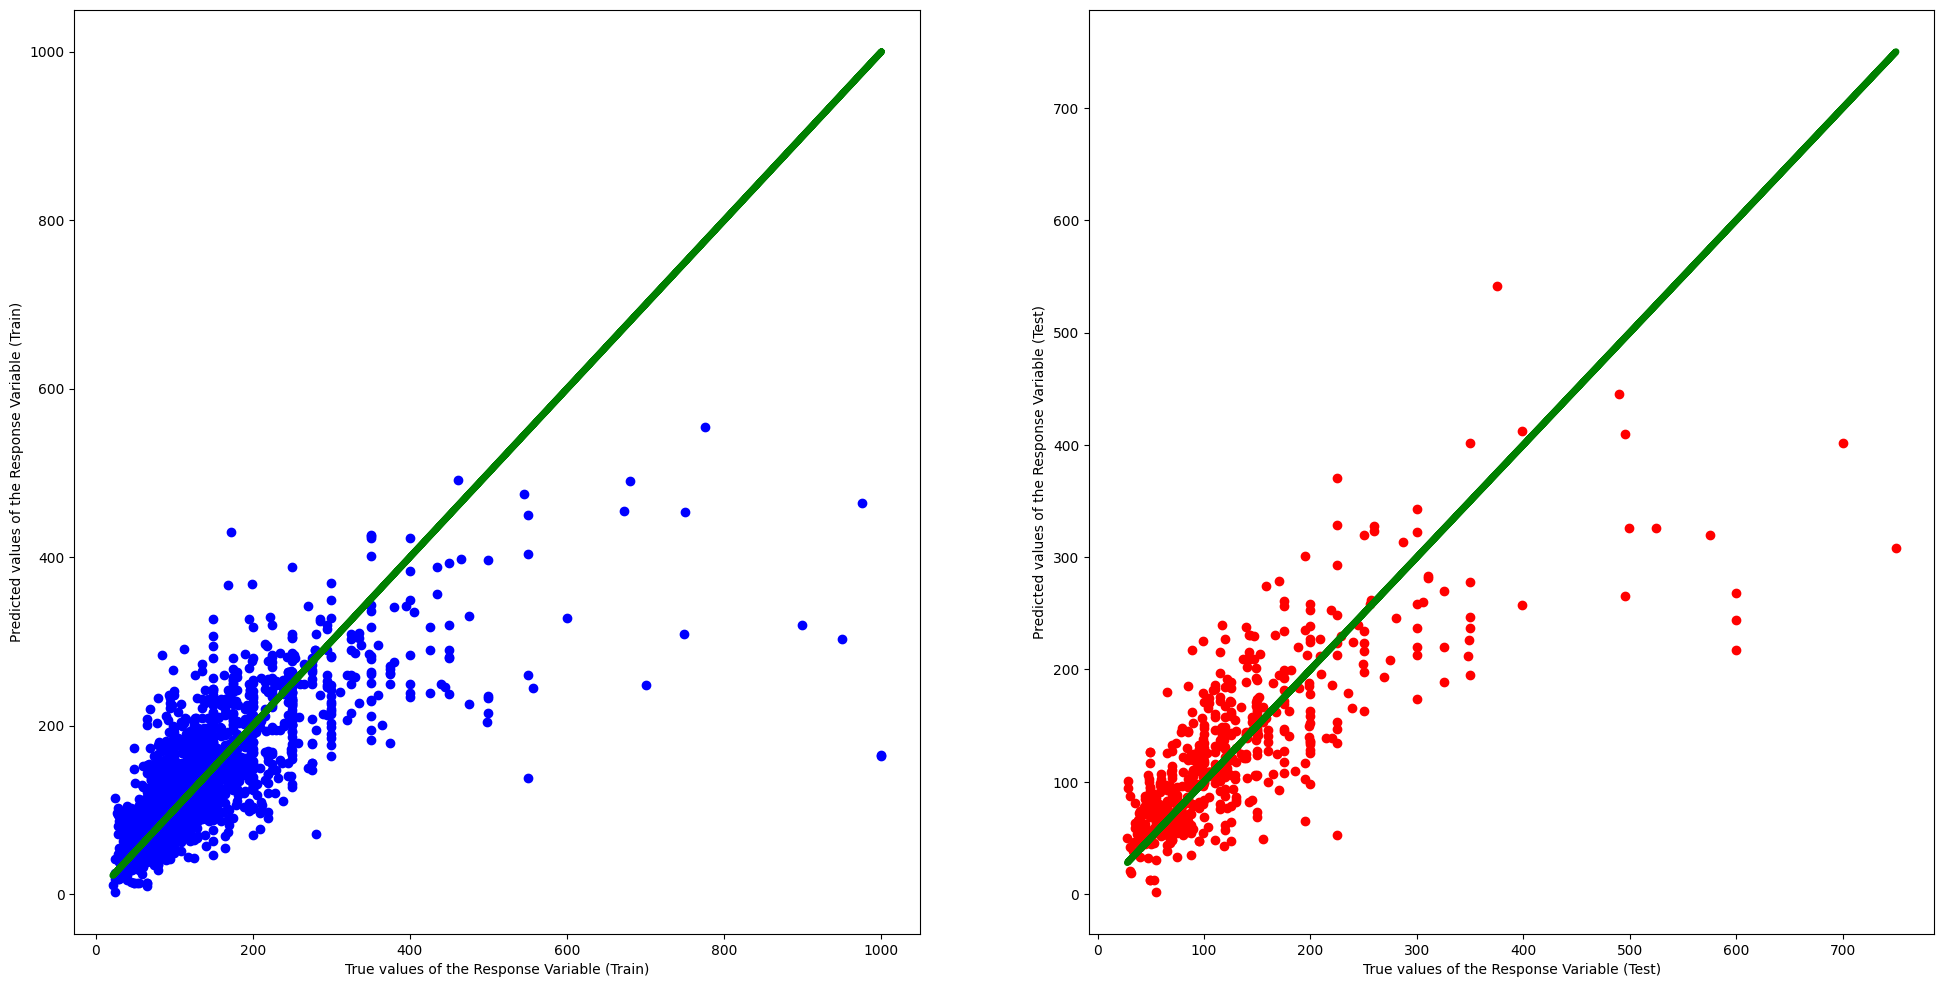

In [49]:
import matplotlib.pyplot as plt
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, trainPredictionLR, color = "blue")
axes[0].plot(y_train, y_train, 'g-', linewidth = 5)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, testPredictionLR, color = "red")
axes[1].plot(y_test, y_test, 'g-', linewidth = 5)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

### 2-Xgboost Model

In [120]:
import xgboost as xgb
# Fitting and Training the model for Train & Test sets
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.017,
                max_depth = 3, alpha = 10, n_estimators = 2000)

xgb_reg.fit(X_train,y_train)

# Predicting using the model
trainPredictin_xgb_reg = xgb_reg.predict(X_train)
testPredictin_xgb_reg = xgb_reg.predict(X_test)

c:\Users\Mohamed Hussein\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [121]:
print('\nModel evaluation on train data : \n')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, trainPredictin_xgb_reg)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, trainPredictin_xgb_reg)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

print ('\nModel evaluation on test data : \n' )

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, testPredictin_xgb_reg)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, testPredictin_xgb_reg)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Model evaluation on train data : 

Mean Absolute Error (MAE): 28.984153739170956
Mean Squared Error (MSE): 2296.21485776438
Root Mean Squared Error (RMSE): 47.91883614784879

Model evaluation on test data : 

Mean Absolute Error (MAE): 34.26704025268555
Mean Squared Error (MSE): 3346.0420991291744
Root Mean Squared Error (RMSE): 57.84498335317571


In [123]:
# # Ploting decision tree 
# xgb.plot_tree(xgb_reg, num_trees=0, rankdir='LR')
# fig = plt.gcf()
# fig.set_size_inches(15, 20)

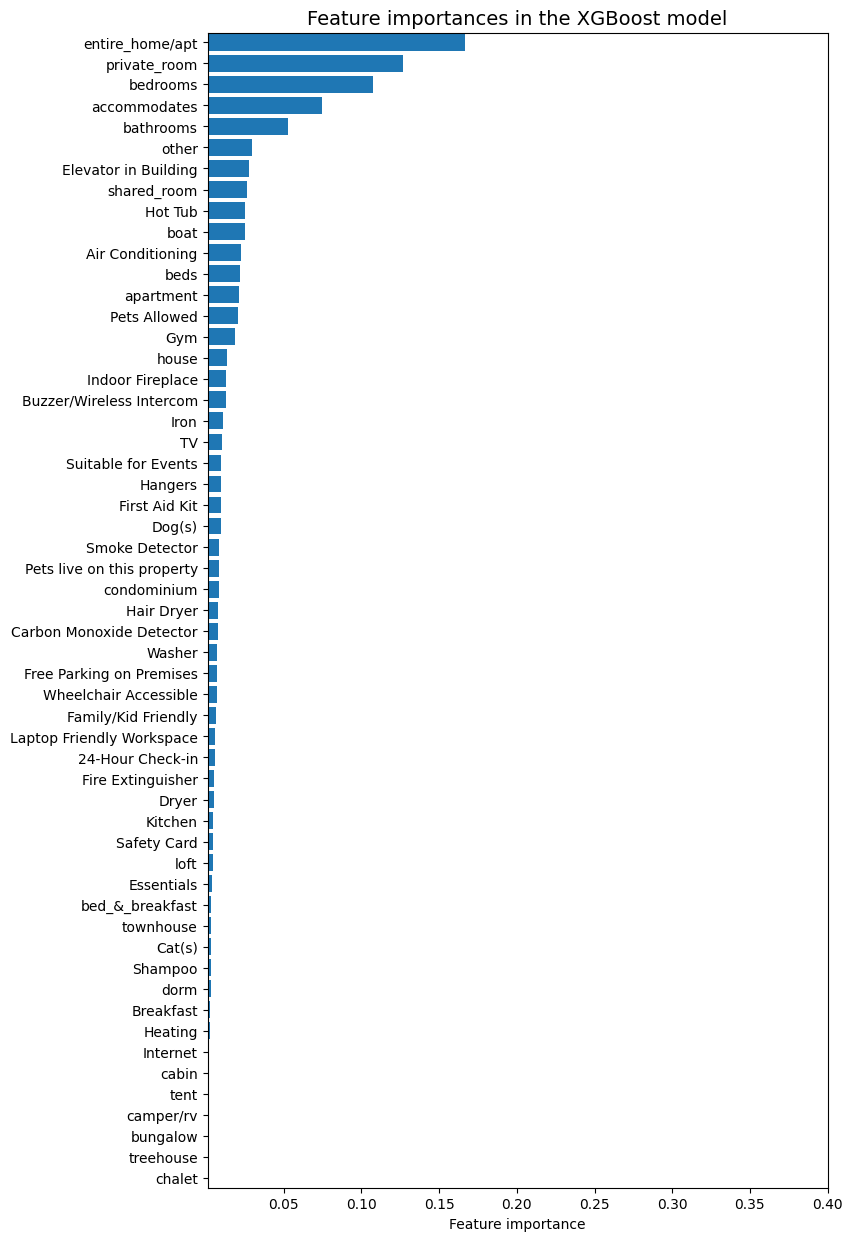

In [124]:
# Weightage/Importance of each variable 
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
# ft_weights_xgb_reg
# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.001)
plt.xlim(0.001, 0.4)
plt.show()

Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

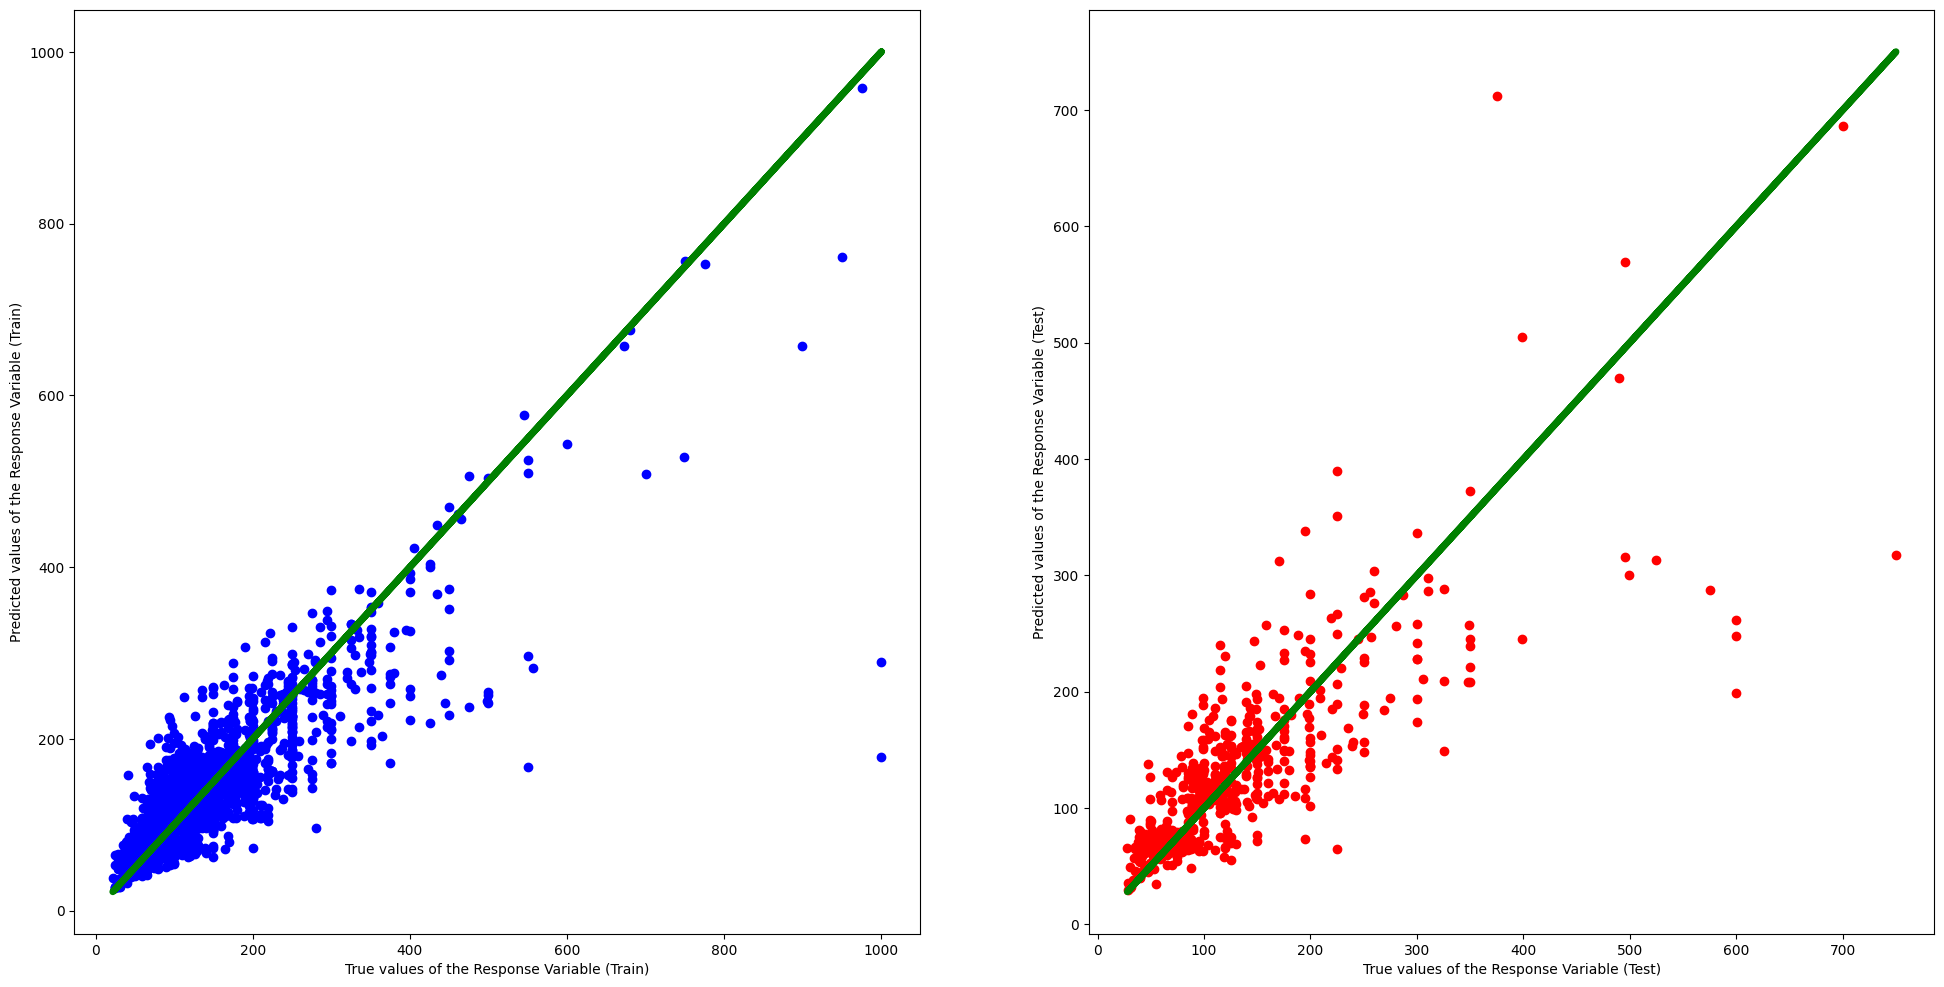

In [125]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, trainPredictin_xgb_reg, color = "blue")
axes[0].plot(y_train, y_train, 'g-', linewidth = 5)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, testPredictin_xgb_reg, color = "red")
axes[1].plot(y_test, y_test, 'g-', linewidth = 5)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

> ##### Points that lie on or near the diagonal line means that the values predicted by the XGBoost Regression model are highly accurate. If the points are away from the diagonal line, the points have been wrongly predicted.

### 3- Catboost model

In [147]:
from catboost import CatBoostRegressor
# Creating and fitting the model
CatB=CatBoostRegressor(iterations=4000, depth=3, learning_rate=0.0565,loss_function='RMSE')
CatB.fit(X_train, y_train,plot=True);

# Predicting based on the model
trainPrediction_CatB = CatB.predict(X_train)
testPrediction_CatB = CatB.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 91.9436559	total: 1.33ms	remaining: 5.32s
1:	learn: 89.9009792	total: 3.03ms	remaining: 6.06s
2:	learn: 88.2136493	total: 4.69ms	remaining: 6.25s
3:	learn: 86.4217911	total: 5.89ms	remaining: 5.89s
4:	learn: 84.6306090	total: 7.21ms	remaining: 5.76s
5:	learn: 83.0699194	total: 8.53ms	remaining: 5.68s
6:	learn: 81.6728585	total: 9.89ms	remaining: 5.64s
7:	learn: 80.2746543	total: 11.2ms	remaining: 5.57s
8:	learn: 79.0092446	total: 12.3ms	remaining: 5.47s
9:	learn: 77.9603387	total: 13.6ms	remaining: 5.43s
10:	learn: 76.8692399	total: 14.9ms	remaining: 5.41s
11:	learn: 75.8481602	total: 16.3ms	remaining: 5.42s
12:	learn: 74.8974107	total: 17.6ms	remaining: 5.41s
13:	learn: 74.0290044	total: 19.1ms	remaining: 5.43s
14:	learn: 73.1661369	total: 20.4ms	remaining: 5.43s
15:	learn: 72.3675994	total: 21.9ms	remaining: 5.46s
16:	learn: 71.5445355	total: 23.5ms	remaining: 5.51s
17:	learn: 70.9777081	total: 24.8ms	remaining: 5.49s
18:	learn: 70.3736749	total: 26.2ms	remaining: 5.48s
19:

In [150]:
print('\nModel evaluation on train data : \n')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, trainPrediction_CatB)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, trainPrediction_CatB)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
print ('\nModel evaluation on test data : \n' )

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, testPrediction_CatB)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, testPrediction_CatB)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)



Model evaluation on train data : 

Mean Absolute Error (MAE): 24.594914160758172
Mean Squared Error (MSE): 1507.3185832788558
Root Mean Squared Error (RMSE): 38.82420099987707

Model evaluation on test data : 

Mean Absolute Error (MAE): 35.67061385585586
Mean Squared Error (MSE): 3452.0752176920273
Root Mean Squared Error (RMSE): 58.75436339279005


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

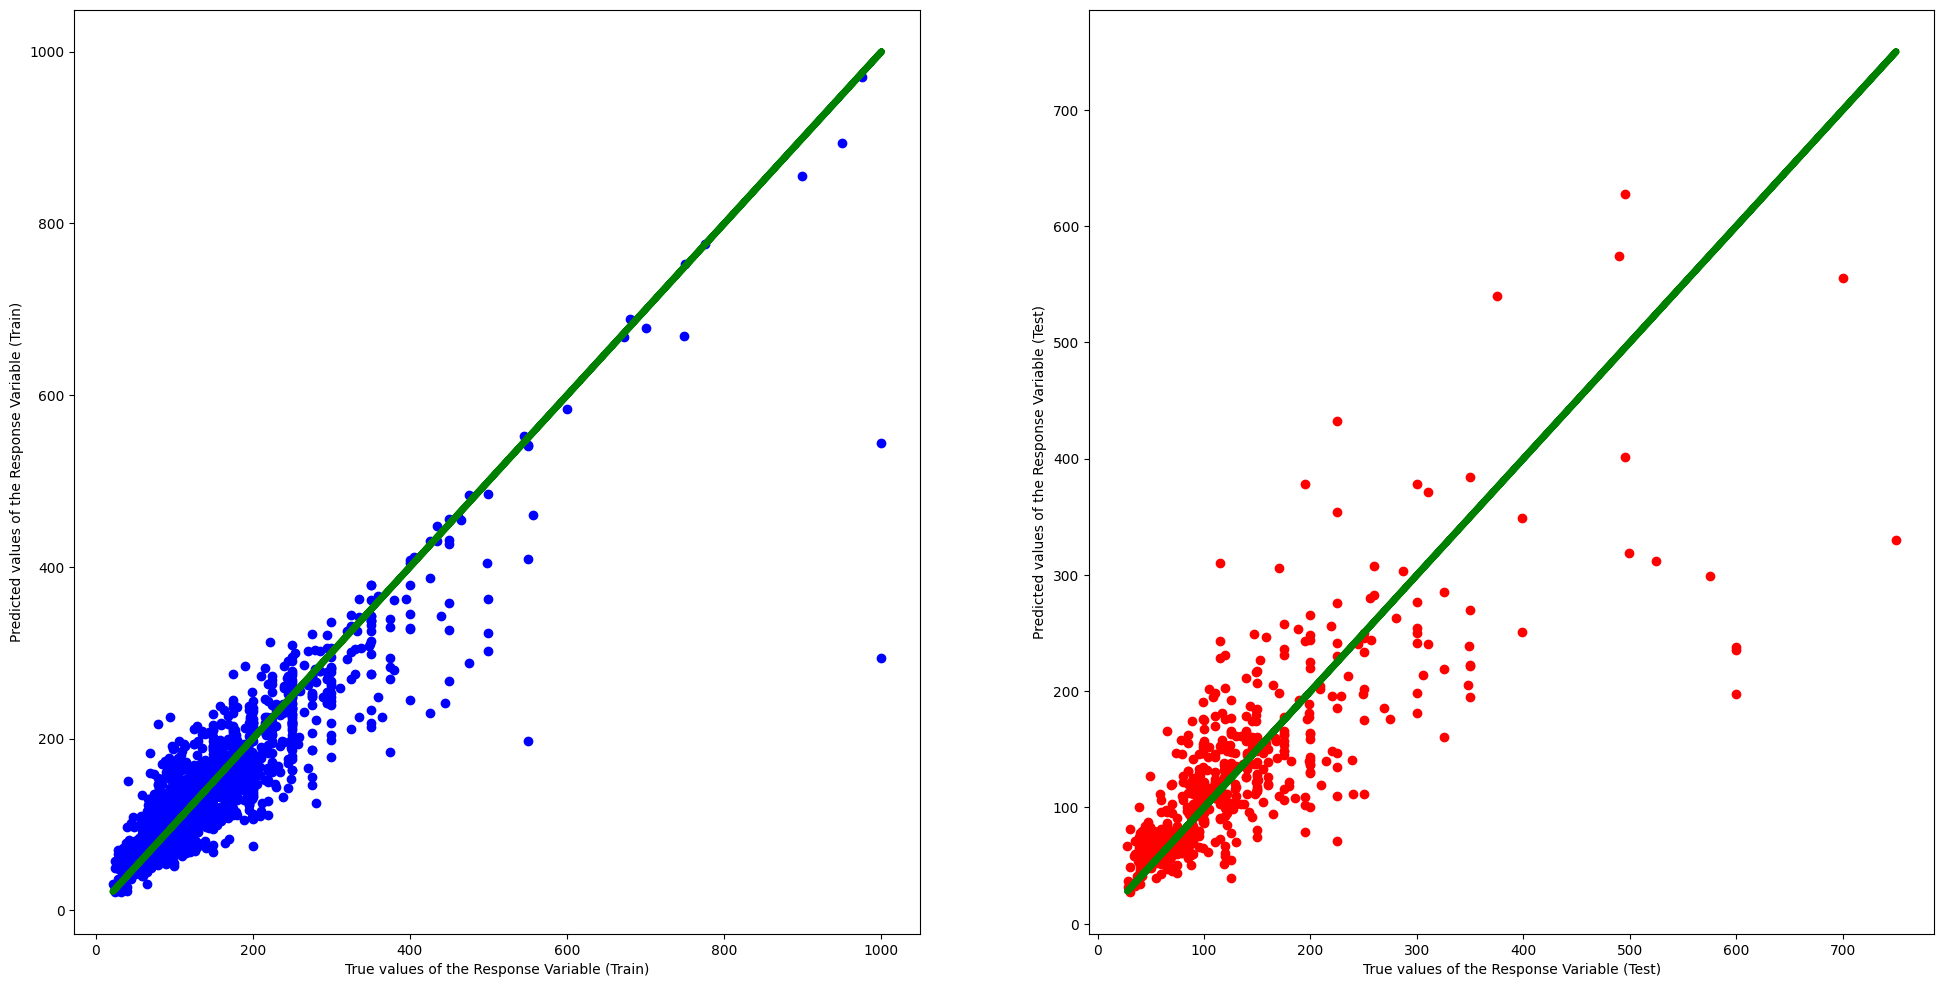

In [151]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, trainPrediction_CatB, color = "blue")
axes[0].plot(y_train, y_train, 'g-', linewidth = 5)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, testPrediction_CatB, color = "red")
axes[1].plot(y_test, y_test, 'g-', linewidth = 5)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

### 4 - Random Forest

In [157]:
# Creating and fitting the model
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators=2000, max_depth=40,min_samples_split = 50,
                           max_leaf_nodes = 70,max_features = 12).fit(X_train,y_train)

# Predicting the training and testing sets
trainPredictin_RF = RF.predict(X_train)
testPredictin_RF =RF.predict(X_test)

c:\Users\Mohamed Hussein\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [158]:
print('\nModel evaluation on train data : \n')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, trainPredictin_RF)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, trainPredictin_RF)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

print ('\nModel evaluation on test data : \n' )

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, testPredictin_RF)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, testPredictin_RF)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Model evaluation on train data : 

Mean Absolute Error (MAE): 32.61332752775852
Mean Squared Error (MSE): 3287.241943553064
Root Mean Squared Error (RMSE): 57.33447430257876

Model evaluation on test data : 

Mean Absolute Error (MAE): 34.33974152347145
Mean Squared Error (MSE): 3348.5836238901284
Root Mean Squared Error (RMSE): 57.86694759437488


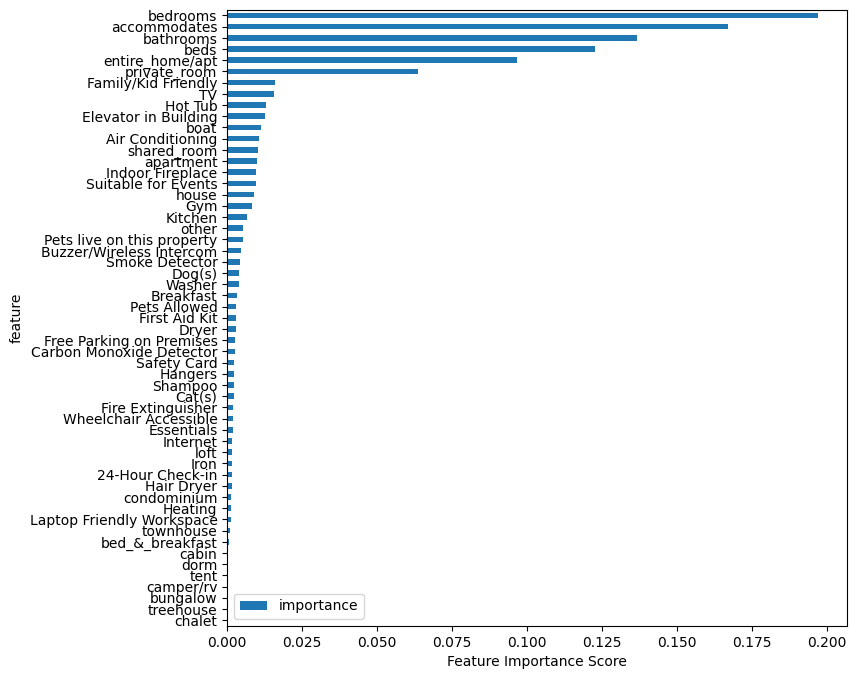

In [153]:
importancesRF = RF.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train.columns)
feat_imp1.sort_values('Weight', inplace=True)
feat_imp = pd.DataFrame({'importance':RF.feature_importances_})  
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()


### 5 - kmeans Clustring

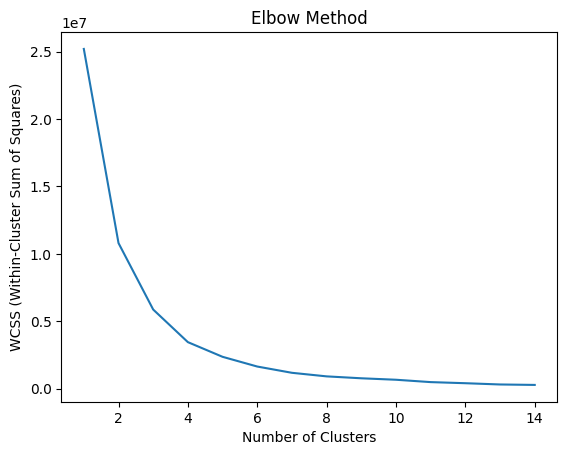

In [148]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


# Choose the number of clusters using the Elbow Method
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(transformed_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to determine the best number of clusters
plt.plot(range(1, 15), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()




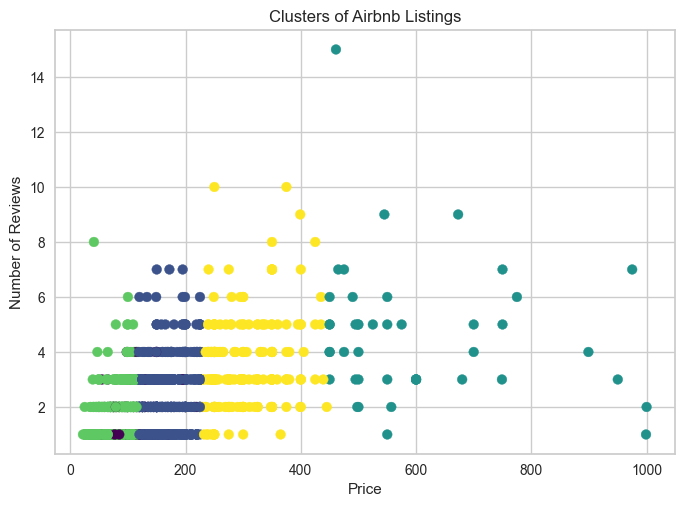

In [47]:
#from Graph we can see that the best number of clusters is 5    
# Create and fit the KMeans model
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(transformed_df)
# plot the clusters 
plt.scatter(transformed_df['price'], transformed_df['beds'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.title('Clusters of Airbnb Listings')
plt.show()

